In [104]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import h5py
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#%qtconsole

In [105]:
gcoll = 20.369416384745456
q = 2.114458016776569
quali = 914
fr = 3.2981e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 12.588635388480524
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

11.33619992429376


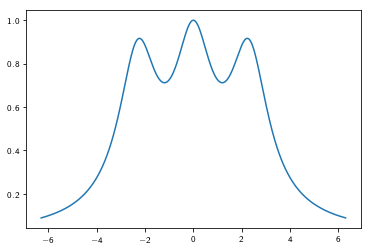

In [106]:
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.plot(spins, pdf/max(pdf))

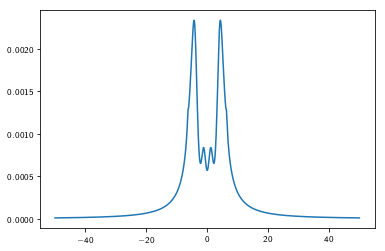

In [107]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.plot(deltaarr/2/np.pi, (losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [177]:
decaytime = 1220e-3
dt = 4e-3
tlistdecay = np.arange(0, decaytime+dt, dt)
scale = 0.001
init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

In [178]:
filename = '/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/LogFiles/SyncFolderAcqiris/Measurements/2016/20190124_MeasurementRun112/20190327_oct_maxampl1_finer/genetic.mat'
data = scipy.io.loadmat(filename)
ilist = data['puls'][:,1]
qlist = data['puls'][:,2]
tlist = data['puls'][:,0]

In [179]:
solpump, soldecay, infodict = solve_mbes(mbes_soc, init, pdf, tlist, tlistdecay, ilist*scale, qlist*scale, tlist, kappa, deltac, gs, gperp, spins, gpar)
a2pump = abs(solpump[:,0])**2
a2decay = abs(soldecay[:,0])**2
maxsim = max(max(a2pump), max(a2decay))

In [180]:
dataexp = scipy.io.loadmat('/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/LogFiles/SyncFolderAcqiris/Measurements/2016/20190124_MeasurementRun112/20190327_oct_maxampl1_finer/data.mat')

datidx = dataexp['data'][0].dtype.names.index('scan')
noiseidx = dataexp['data'][0].dtype.names.index('noisefloor')

datalin = dataexp['data'][0][0][datidx][0][30]
imeas = datalin[2]-np.mean(datalin[2][3500:4000])
qmeas = datalin[3]-np.mean(datalin[3][3500:4000])
a2exp = (imeas**2+qmeas**2)
texp = datalin[0]

noisefloor = dataexp['data'][0][0][noiseidx][0][0]
tnoise = np.squeeze(noisefloor[0])
inoise = np.squeeze(noisefloor[2]-np.mean(noisefloor[2][3500:4000]))
qnoise = np.squeeze(noisefloor[3]-np.mean(noisefloor[3][3500:4000]))
a2noise = inoise**2+qnoise**2

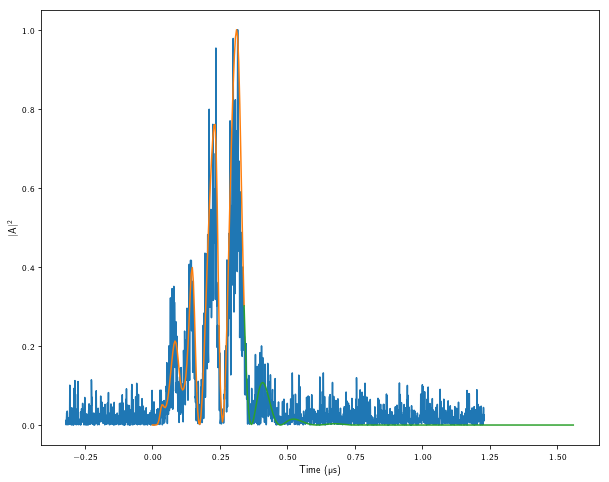

In [181]:
toff = 0.72
idxstart = 800
idx = 3900
plt.figure(figsize=(10,8))

a2all = (np.squeeze(imeas)-np.squeeze(inoise))**2+(np.squeeze(qmeas)-np.squeeze(qnoise))**2
#plt.plot(np.squeeze(texp)[idxstart:idx]*1e6-toff, a2exp[idxstart:idx]/max(a2exp))
plt.plot(np.squeeze(texp)[idxstart:idx]*1e6-toff, a2all[idxstart:idx]/max(a2all[idxstart:idx]))
plt.plot(tlist, a2pump/maxsim, tlistdecay+tlist[-1], a2decay/maxsim)

plt.xlabel('Time (µs)')
plt.ylabel('$|\mathrm{A}|^2$');

## Compare with data

In [184]:
datalin = dataexp['data'][0][0][datidx][0]
pin = np.arange(-30, 0.1, 0.5)
aref = 0.56

ain = aref*10**(pin/20)
texp2 = np.squeeze(datalin[0][0])[idxstart:idx]*1e6-toff
tsim = np.hstack((tlist, tlist[-1]+tlistdecay))

a2listsimpump = {}
a2listsimdecay = {}
a2listdat = {}
invlistsimpump = {}
invlistsimdecay = {}

for i, dat in enumerate(pin):
    if i<len(datalin):
        imeas = datalin[i][2]-np.mean(datalin[i][2][3500:4000])
        qmeas = datalin[i][3]-np.mean(datalin[i][3][3500:4000])
        a2exp = (np.squeeze(imeas)-np.squeeze(inoise))**2+(np.squeeze(qmeas)-np.squeeze(qnoise))**2
        expdat = np.squeeze(a2exp[idxstart:idx])
        a2listdat[dat] = expdat
    
    asolpump, asoldecay, infodict = solve_mbes(mbes_soc, init, pdf, tlist, tlistdecay, ilist*ain[i], qlist*ain[i],tlist, kappa, deltac, gs, gperp, spins, gpar)
    a2pump2 = asolpump[:,0]
    invpump = np.real(np.sum(asolpump[:,2::2], axis=1))
    invdecay= np.real(np.sum(asoldecay[:,2::2], axis=1))
    a2decay2 = asoldecay[:,0]
    
    a2listsimpump[dat] =  abs(a2pump2)**2
    a2listsimdecay[dat] = abs(a2decay2)**2
    invlistsimpump[dat] = invpump
    invlistsimdecay[dat] = invdecay


a2dat = []
a2sim = []
for i, dat in enumerate(pin):
    if dat in a2listdat.keys():
        a2dat.append(a2listdat[dat])

    a2pump2 = a2listsimpump[dat]
    a2decay2 = a2listsimdecay[dat]
    a2sim.append(np.hstack((a2pump2, a2decay2)))

tbef = np.arange(-0.32, 0, dt)
a2sim = np.asarray(a2sim)
a2empt = np.zeros((len(pin), len(tbef)))
a2dat = np.asarray(a2dat)

Input Power: -11


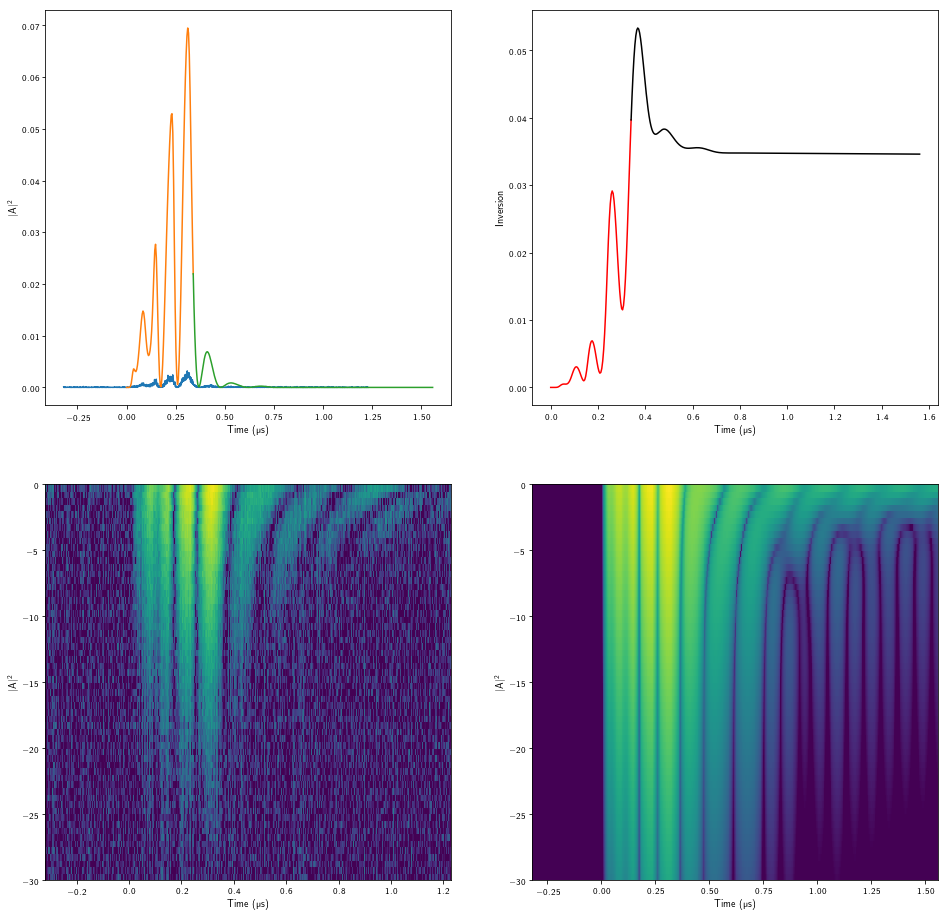

In [185]:
scalem = 2.4e-3
pdatlist = [-11]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,16))
ax1.set_xlabel('Time (µs)')
ax2.set_xlabel('Time (µs)')
ax1.set_ylabel('$|\mathrm A|^2$');
ax2.set_ylabel('Inversion');

for i, val in enumerate(pdatlist):
    print("Input Power: %d"%val)
    if val in a2listdat.keys():
        ax1.plot(texp2, a2listdat[val])
    ax1.plot(tlist, a2listsimpump[val]*scalem, tlistdecay+tlist[-1], a2listsimdecay[val]*scalem)
    ax2.plot(tlist, (1+invlistsimpump[val])/2, 'r', tlistdecay+tlist[-1], (1+invlistsimdecay[val])/2, 'k')

ax3.set_xlabel('Time (µs)')
ax3.set_ylabel('$|\mathrm A|^2$');
ax4.set_xlabel('Time (µs)')
ax4.set_ylabel('$|\mathrm A|^2$');

minclip = 0.00001
ax3.pcolormesh(texp2, sorted(list(a2listdat.keys())), a2dat, norm=LogNorm(vmin=minclip, vmax=a2dat.max()))
ax4.pcolormesh(np.hstack((tbef, tsim)), pin, np.clip(np.hstack((a2empt, a2sim)),minclip, None), norm=LogNorm(vmin=minclip, vmax=a2sim.max()))


In [102]:
decaytimeup = 1500e-2
dtup = 8e-2
tlistdecayup = np.arange(0, decaytimeup+dtup, dtup)
initup = np.ones(nbins*2+1)*1
initup[0] = 0
initup[1::2] = 0
powerin = 1e-16
asolpumpup, asoldecayup, infodict = solve_mbes(mbes, initup, pdf, tlist, tlistdecayup, powerin, kappa, deltac, gs, gperp, spins, gpar)
a2pump2up = abs(asolpumpup[:,0])**2
invpumpup = np.real(np.sum(asolpumpup[:,2::2], axis=1))
invdecayup = np.real(np.sum(asoldecayup[:,2::2], axis=1))
a2decay2up = abs(asoldecayup[:,0])**2

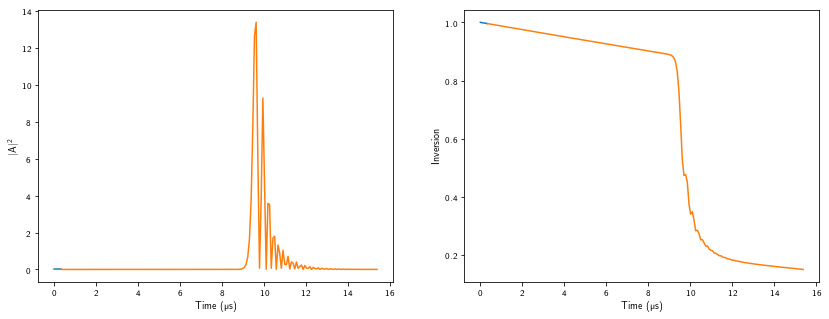

In [103]:
fig, ((ax1, ax2)) = plt.subplots(1,2 ,figsize=(14,5))
ax1.set_xlabel('Time (µs)')
ax2.set_xlabel('Time (µs)')
ax1.set_ylabel('$|\mathrm A|^2$');
ax2.set_ylabel('Inversion');

ax1.plot(tlist, a2pump2up, tlistdecayup+tlist[-1], a2decay2up)
ax2.plot(tlist, invpumpup, tlistdecayup+tlist[-1], invdecayup)